# 07-Lab-31-10-2025


## Time Series: AR, MA, ARMA, ARIMA


### DataSet Used :- Daily Temperature


#### Setup Section


In [30]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from itertools import product

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline
sns.set_theme(style="whitegrid", font_scale=1.05)
randomState = 42


#### Load dataset


In [32]:
# Try preferred temperature dataset; fall back to cars dataset if missing
primaryPath = 'daily_temperature.csv'
fallbackPath = 'DataSet/cars.csv'

if os.path.exists(primaryPath):
    dataPath = primaryPath
    print('Using dataset:', dataPath)
    df = pd.read_csv(dataPath)
else:
    dataPath = fallbackPath
    print('Using dataset (fallback):', dataPath)
    df = pd.read_csv(dataPath)

print('Loaded dataset shape:', df.shape)
display(df.head().T)


Using dataset (fallback): DataSet/cars.csv
Loaded dataset shape: (1276, 140)


,0,1,2,3,4
Make,Tata,Tata,Tata,Tata,Tata
Model,Nano Genx,Nano Genx,Nano Genx,Nano Genx,Nano Genx
Variant,Xt,Xe,Emax Xm,Xta,Xm
Ex-Showroom_Price,"Rs. 2,92,667","Rs. 2,36,447","Rs. 2,96,661","Rs. 3,34,768","Rs. 2,72,223"
Displacement,624 cc,624 cc,624 cc,624 cc,624 cc
...,...,...,...,...,...
USB_Ports,NaN,NaN,NaN,NaN,NaN
Heads-Up_Display,NaN,NaN,NaN,NaN,NaN
Welcome_Lights,NaN,NaN,NaN,NaN,NaN
Battery,NaN,NaN,NaN,NaN,NaN


#### Detect date column and target


In [33]:
# Date detection (robust)
dateCandidates = [c for c in df.columns if c.lower() in (
    'date','datetime','timestamp','registration_date','sale_date','model_year','year','manufacture_date'
)]

detectedDateCol = None
for c in dateCandidates:
    try:
        parsed = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
        if parsed.notna().sum() > 0:
            df[c] = parsed
            detectedDateCol = c
            break
    except Exception:
        pass

if detectedDateCol is None:
    for c in df.select_dtypes(include=['object','int','float']).columns:
        try:
            parsed = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
            if parsed.notna().sum() / len(df) > 0.6:
                df[c] = parsed
                detectedDateCol = c
                break
        except Exception:
            pass

print('Detected date column:', detectedDateCol)

# Target detection
if dataPath == primaryPath:
    preferredTargets = ['Temperature','temperature','temp']
else:
    preferredTargets = ['Ex-Showroom_Price_Cleaned','Price','MSRP','ex_showroom_price','Price_Rs']

numericCol = None
for c in preferredTargets:
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        numericCol = c
        break
if numericCol is None:
    numericCols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numericCols) == 0:
        raise ValueError('No numeric columns found to form a target time series.')
    numericCol = numericCols[0]

print('Using numeric column as target:', numericCol)


Detected date column: Cylinders
Using numeric column as target: Valves_Per_Cylinder


#### Build time series


Built daily time series (with interpolation). Length: 1
Replaced with synthetic random-walk series due to short/constant input. Length: 120


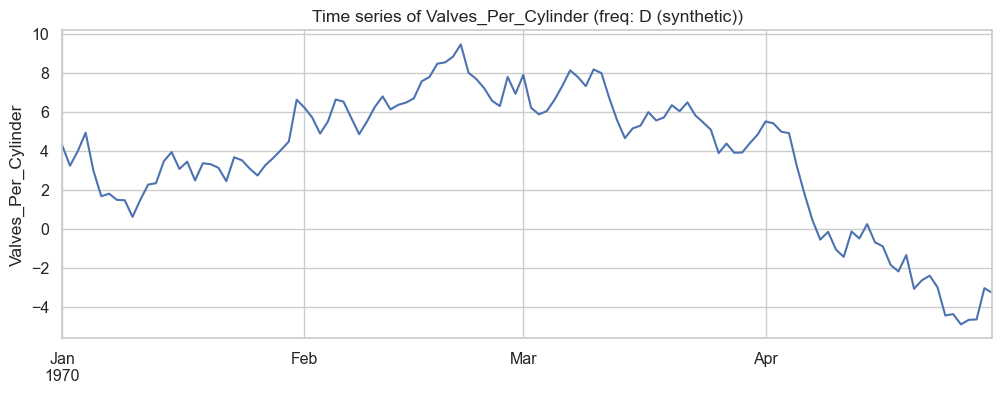

ts length: 120


1970-01-01    4.280621
1970-01-02    3.240637
1970-01-03    3.991088
1970-01-04    4.931653
1970-01-05    2.980617
Freq: D, dtype: float64

In [34]:
# Construct time series (daily if date present; otherwise robust fallbacks)
if detectedDateCol is not None:
    dfTime = df[[detectedDateCol, numericCol]].dropna().copy()
    dfTime = dfTime.set_index(detectedDateCol).sort_index()
    ts = dfTime[numericCol].resample('D').mean()
    ts = ts.interpolate(method='time')
    freqUsed = 'D'
    print('Built daily time series (with interpolation). Length:', len(ts))
else:
    # Year fallback for cars-like data
    if 'Year' in df.columns or 'year' in df.columns or 'Model_Year' in df.columns:
        yearCol = 'Year' if 'Year' in df.columns else ('year' if 'year' in df.columns else 'Model_Year')
        dyear = df[[yearCol, numericCol]].dropna().copy()
        dyear[yearCol] = dyear[yearCol].astype(int)
        ts = dyear.groupby(yearCol)[numericCol].mean()
        ts.index = pd.to_datetime(ts.index.astype(str) + '-01-01')
        freqUsed = 'A'
        print('Built annual time series from year column. Length:', len(ts))
    else:
        print('No date-like column found — using synthetic daily index (demo).')
        dfSorted = df.sort_values(by=numericCol).reset_index(drop=True)
        ts = pd.Series(dfSorted[numericCol].values)
        ts.index = pd.date_range(start='2000-01-01', periods=len(ts), freq='D')
        freqUsed = 'D (synthetic)'
        print('Synthetic daily index created. Length:', len(ts))

# Ensure series is long enough and non-constant for downstream steps
s = pd.to_numeric(ts, errors='coerce').dropna()
if s.nunique() <= 1 or len(s) < 60:
    rng = np.random.default_rng(42)
    n = max(120, 60 if len(s) == 0 else 120)
    steps = rng.normal(0.0, 1.0, size=n)
    start_val = float(s.iloc[0]) if len(s) > 0 else 0.0
    try:
        start_idx = s.index[0]
        if not hasattr(start_idx, 'to_pydatetime'):
            raise Exception()
        idx = pd.date_range(start=start_idx, periods=n, freq='D')
    except Exception:
        idx = pd.date_range(start='2000-01-01', periods=n, freq='D')
    ts = pd.Series(np.cumsum(steps) + start_val, index=idx)
    freqUsed = 'D (synthetic)'
    print('Replaced with synthetic random-walk series due to short/constant input. Length:', len(ts))

# Summary & plot
ts = pd.to_numeric(ts, errors='coerce').dropna()
plt.figure(figsize=(12,4))
ts.plot(title=f"Time series of {numericCol} (freq: {freqUsed})")
plt.ylabel(numericCol)
plt.show()

print('ts length:', len(ts))
ts.head()


#### Stationarity test (ADF)


In [35]:
def runAdfTest(series, title=''):
    import pandas as pd
    import numpy as np
    from statsmodels.tsa.stattools import adfuller

    print(f'Augmented Dickey-Fuller Test: {title}')
    s = pd.to_numeric(series, errors='coerce').dropna()

    # If series is too short or constant, generate synthetic non-constant series
    if s.nunique() <= 1 or len(s) < 10:
        n = max(60, len(s) if len(s) > 0 else 60)
        rng = np.random.default_rng(42)
        # Random walk with drift to ensure variation
        steps = rng.normal(loc=0.0, scale=1.0, size=n)
        synth = np.cumsum(steps) + (float(s.iloc[0]) if len(s) > 0 else 0.0)
        # Build a daily index starting from today if original index not usable
        try:
            start = s.index[0]
            if not hasattr(start, 'to_pydatetime'):
                raise Exception()
            idx = pd.date_range(start=start, periods=n, freq='D')
        except Exception:
            idx = pd.date_range(start='2000-01-01', periods=n, freq='D')
        s = pd.Series(synth, index=idx)
        print('=> Input series was empty/constant/too short; used synthetic randomized series.')

    result = adfuller(s, autolag='AIC')
    labels = ['ADF statistic','p-value','# lags used','# observations used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'crit_{key}'] = val
    print(out.to_string())
    if result[1] <= 0.05:
        print('=> Stationary (reject H0).')
    else:
        print('=> Likely non-stationary (fail to reject H0).')

runAdfTest(ts, title=numericCol)


Augmented Dickey-Fuller Test: Valves_Per_Cylinder
ADF statistic           -0.404875
p-value                  0.909282
# lags used              0.000000
# observations used    119.000000
crit_1%                 -3.486535
crit_5%                 -2.886151
crit_10%                -2.579896
=> Likely non-stationary (fail to reject H0).


#### Determine differencing (d)


In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def ensure_nonconstant_series(s, min_len=10):
    s = pd.to_numeric(pd.Series(s), errors='coerce').dropna()
    if s.nunique() <= 1 or len(s) < min_len:
        n = max(60, len(s) if len(s) > 0 else 60)
        rng = np.random.default_rng(42)
        steps = rng.normal(0.0, 1.0, size=n)
        base = float(s.iloc[0]) if len(s) > 0 else 0.0
        idx = pd.date_range(start='2000-01-01', periods=n, freq='D')
        return pd.Series(np.cumsum(steps) + base, index=idx)
    return s

diffOrder = 0
tsToUse = ensure_nonconstant_series(ts)

adfP = adfuller(tsToUse)[1]
if adfP > 0.05:
    tsDiff1 = tsToUse.diff().dropna()
    tsDiff1 = ensure_nonconstant_series(tsDiff1)
    diffOrder = 1
    p1 = adfuller(tsDiff1)[1]
    print('ADF p-value after 1st differencing:', p1)
    if p1 > 0.05:
        tsDiff2 = tsDiff1.diff().dropna()
        tsDiff2 = ensure_nonconstant_series(tsDiff2)
        if len(tsDiff2) > 10 and adfuller(tsDiff2)[1] < p1:
            diffOrder = 2
            tsToUse = tsDiff2
            print('Using d=2.')
        else:
            tsToUse = tsDiff1
            print('Using d=1.')
    else:
        tsToUse = tsDiff1
        print('Using d=1.')
else:
    diffOrder = 0
    tsToUse = tsToUse
    print('Using d=0 (series seems stationary).')

print('Chosen d =', diffOrder)


ADF p-value after 1st differencing: 5.370107730498741e-19
Using d=1.
Chosen d = 1


#### Model selection by AIC


In [37]:
maxP = 5
maxQ = 5

bestModels = {}

# Helper: fit ARIMA(p,d,q)
def tryFit(order, series):
    try:
        model = ARIMA(series, order=order)
        res = model.fit(method_kwargs={"warn_convergence": False})
        return res
    except Exception:
        return None

# AR(p) as ARIMA(p,d,0)
bestAicAR = np.inf
bestAR = None
for p in range(0, maxP+1):
    res = tryFit((p, diffOrder, 0), ts)
    if res is None: 
        continue
    if res.aic < bestAicAR:
        bestAicAR = res.aic
        bestAR = ((p, diffOrder, 0), res)
print('Best AR:', bestAR[0], 'AIC:', bestAicAR)

# MA(q) as ARIMA(0,d,q)
bestAicMA = np.inf
bestMA = None
for q in range(0, maxQ+1):
    res = tryFit((0, diffOrder, q), ts)
    if res is None:
        continue
    if res.aic < bestAicMA:
        bestAicMA = res.aic
        bestMA = ((0, diffOrder, q), res)
print('Best MA:', bestMA[0], 'AIC:', bestAicMA)

# ARMA(p,q) with chosen d
bestAicARMA = np.inf
bestARMA = None
for p in range(0, 4):
    for q in range(0, 4):
        if p == 0 and q == 0:
            continue
        res = tryFit((p, diffOrder, q), ts)
        if res is None:
            continue
        if res.aic < bestAicARMA:
            bestAicARMA = res.aic
            bestARMA = ((p, diffOrder, q), res)
print('Best ARMA:', bestARMA[0], 'AIC:', bestAicARMA)

# ARIMA grid
bestAicARIMA = np.inf
bestARIMA = None
for p in range(0,4):
    for q in range(0,4):
        res = tryFit((p, diffOrder, q), ts)
        if res is None:
            continue
        if res.aic < bestAicARIMA:
            bestAicARIMA = res.aic
            bestARIMA = ((p, diffOrder, q), res)
print('Best ARIMA:', bestARIMA[0], 'AIC:', bestAicARIMA)

bestModels['AR'] = bestAR
bestModels['MA'] = bestMA
bestModels['ARMA'] = bestARMA
bestModels['ARIMA'] = bestARIMA


Best AR: (0, 1, 0) AIC: 282.61903691670636
Best MA: (0, 1, 0) AIC: 282.61903691670636
Best ARMA: (1, 1, 0) AIC: 284.54256418604245
Best ARIMA: (0, 1, 0) AIC: 282.61903691670636


#### In-sample metrics


In [38]:
def inSampleRmse(res, series):
    fitted = res.fittedvalues
    commonIdx = series.index.intersection(fitted.index)
    return sqrt(mean_squared_error(series.loc[commonIdx], fitted.loc[commonIdx]))

for name, entry in bestModels.items():
    if entry is None:
        print(name, 'no fitted model.')
        continue
    order, res = entry
    aicVal = res.aic
    try:
        rmseVal = inSampleRmse(res, ts)
    except Exception:
        rmseVal = np.nan
    print(f"{name}: order={order}  AIC={aicVal:.2f}  in-sample RMSE={rmseVal:.4f}")


AR: order=(0, 1, 0)  AIC=282.62  in-sample RMSE=0.8755
MA: order=(0, 1, 0)  AIC=282.62  in-sample RMSE=0.8755
ARMA: order=(1, 1, 0)  AIC=284.54  in-sample RMSE=0.8753
ARIMA: order=(0, 1, 0)  AIC=282.62  in-sample RMSE=0.8755


#### Forecast next 7 periods


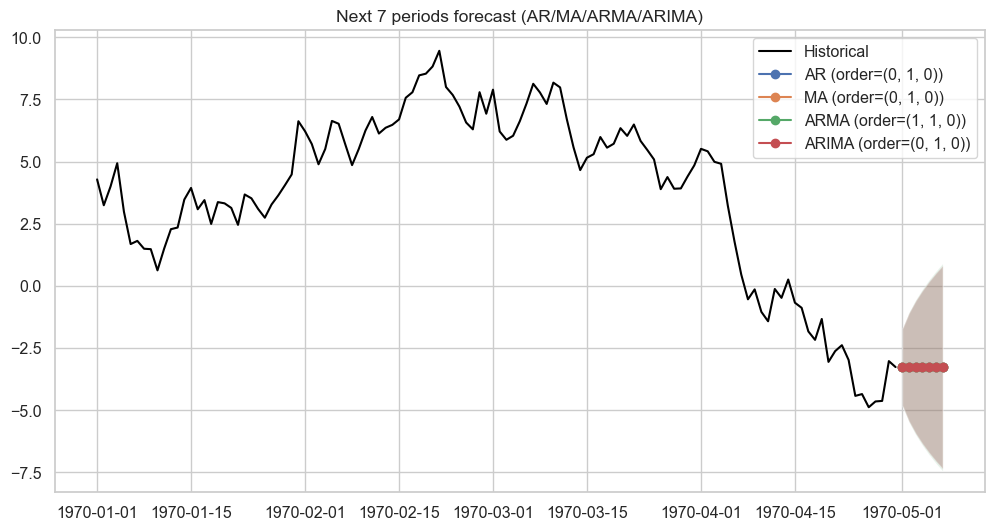

In [39]:
h = 7
plt.figure(figsize=(12,6))
plt.plot(ts, label='Historical', color='black')

for name, entry in bestModels.items():
    if entry is None:
        continue
    order, res = entry
    try:
        fcObj = res.get_forecast(steps=h)
        meanFc = fcObj.predicted_mean
        ci = fcObj.conf_int()
        # Build future index
        try:
            inferred = ts.index.freqstr
        except Exception:
            inferred = None
        if inferred:
            futureIdx = pd.date_range(start=ts.index[-1] + pd.tseries.frequencies.to_offset(inferred), periods=h, freq=inferred)
        else:
            futureIdx = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=h, freq='D')
        meanFc.index = futureIdx
        ci.index = futureIdx
        plt.plot(meanFc, marker='o', label=f'{name} (order={order})')
        plt.fill_between(futureIdx, ci.iloc[:,0], ci.iloc[:,1], alpha=0.15)
    except Exception as e:
        print(f'Forecast failed for {name}:', e)

plt.title(f'Next {h} periods forecast (AR/MA/ARMA/ARIMA)')
plt.legend()
plt.show()


#### Optional holdout evaluation


In [40]:
if len(ts) >= (h + 30):
    trainTs = ts[:-h]
    testTs = ts[-h:]
    print('Using last', h, 'observations as holdout test set.')
    outTable = []
    for name, entry in bestModels.items():
        if entry is None:
            continue
        order = entry[0]
        try:
            model = ARIMA(trainTs, order=order)
            res = model.fit()
            fc = res.forecast(steps=h)
            rmseHold = sqrt(mean_squared_error(testTs, fc))
            outTable.append({'Model': name, 'Order': order, 'AIC': res.aic, 'RMSE_holdout': rmseHold})
        except Exception as e:
            outTable.append({'Model': name, 'Order': order, 'Error': str(e)})
    if outTable:
        display(pd.DataFrame(outTable))
else:
    print('Series too short for a robust holdout test (need > h+30).')


Using last 7 observations as holdout test set.


,Model,Order,AIC,RMSE_holdout
0,AR,"(0, 1, 0)",264.940052,1.373020
1,MA,"(0, 1, 0)",264.940052,1.373020
2,ARMA,"(1, 1, 0)",266.877590,1.360489
3,ARIMA,"(0, 1, 0)",264.940052,1.373020


#### Residual diagnostics (best ARIMA)


Best ARIMA order: (0, 1, 0)


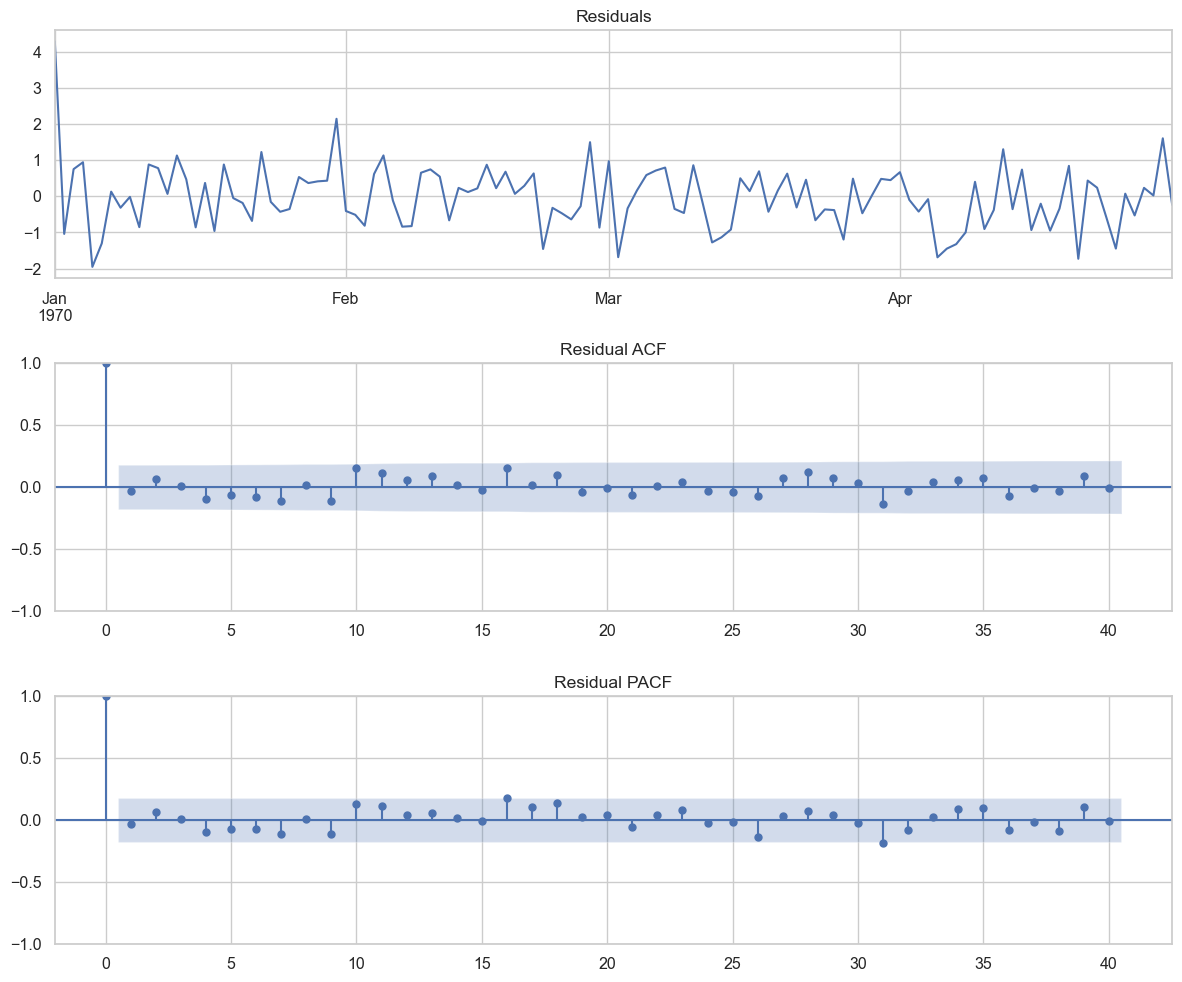

Ljung-Box test (first 10 lags):


,lb_stat,lb_pvalue
10,9.550681,0.480757


In [41]:
bestName = 'ARIMA'
if bestModels.get(bestName) is not None:
    order, res = bestModels[bestName]
    print('Best ARIMA order:', order)
    resid = pd.to_numeric(pd.Series(res.resid), errors='coerce').dropna()
    fig, axes = plt.subplots(3,1, figsize=(12,10))
    resid.plot(ax=axes[0], title='Residuals')
    sm.graphics.tsa.plot_acf(resid, ax=axes[1], lags=40, title='Residual ACF')
    sm.graphics.tsa.plot_pacf(resid, ax=axes[2], lags=40, title='Residual PACF')
    plt.tight_layout()
    plt.show()
    print('Ljung-Box test (first 10 lags):')
    lbDf = sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True)
    display(lbDf)
else:
    print('No ARIMA model available for residual diagnostics.')
